<a href="https://colab.research.google.com/github/AndreBodmer/CAS-Applied-Data-Science/blob/master/Abschlussprojekt_Bodmer_Freunek_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Introduction
- Wrap up of Module 1 and 2


## 2. Agenda
- Running 4 Types of Autoencoders
  - Simple AE
  - Sparse AE
  - Deep AE
  - CNN AE

Problem: AE seems not to learn something useful

Why not? We don't know. Are AE applicable on Text Data?

What have we done to solve the problem? 
- Interpretable ML (t-sne, umap, svm and logistic regression only for patent data) to better understand the latent space and the change of the data after the application of the models

Was it helpful? 
Little evidence for the results but a lot of evidence for authors how these models work


## 3. Outlook for final project
- Apply Word/Text Embeddings Models
- Apply RNN/LSTM for Text Data 
- Use PCA to reduce dimensions because to many dimensions

In [ ]:
# if using google colab
%tensorflow_version 1.x

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
import collections
import time
import codecs

# crc, 12.3.2020, import additional modules for input preparation
import pandas as pd
import os
import shutil
import PIL
import PIL.Image
import PIL.ImageFont
import PIL.ImageOps
import PIL.ImageDraw
###########################################

from tensorflow import keras #frm

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#####################################################################
#Michael 01.11.2020, here is the part with the autencorder according to notebook "Autoencoders by Mykhailo"
import matplotlib.cm as cm

import pandas as pd
from imageio import imread
import pickle
from PIL import Image
from time import time as timer
import requests
import zipfile
import os

import tensorflow.keras.datasets.mnist as mnist

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
import IPython


import umap
from scipy.stats import entropy

tf.logging.set_verbosity(tf.logging.ERROR)

TensorFlow 1.x selected.


#Patent Data

In [ ]:
#################################################
#Michael 28.11.2020 - Idee, wie wir die Einzelnen Schichten des NN analysieren können,
#warum es nicht lernt: Darstellung einer Schicht durch t-SNE oder UMAP
##########################################################

#Michael 09.11.20, Importing the patent data as Pandas frames
dataframe_A61M5_145 = pd.read_excel('A61M5_145.xlsx',header=None)
dataframe_E04C3_04 = pd.read_excel('E04C3_04.xlsx',header=None)
dataframe_F25B30_00 = pd.read_excel('F25B30_00.xlsx',header=None)
dataframe_G01P7_00 = pd.read_excel('G01P7_00.xlsx',header=None)
#dataframe_noise = pd.read_excel('Noise.xlsx',header=None)

document_patent_pandas = pd.concat([dataframe_A61M5_145, dataframe_E04C3_04, dataframe_F25B30_00, dataframe_G01P7_00])
print(document_patent_pandas.head())
print(document_patent_pandas.shape)
round(document_patent_pandas.describe())

                                                   0
0  Infusion pump assembly for infusing e.g. infus...
1  Computer-implemented method for infusing insul...
2  Cassette for use in surgical fluid management ...
3  Apparatus i.e. spring powered ambulatory infus...
4  Flexible reservoir system for storing liquid d...
(1400, 1)


,0
count,1400
unique,1397
top,Condensing unit for air conditioner or heat pu...
freq,2


In [ ]:
#Michael 21.09.2020, we convert the pandas data frames into numpy arrays for easier manipulation.

data_A61M5_145 = np.array(dataframe_A61M5_145)
data_E04C3_04 = np.array(dataframe_E04C3_04)
data_F25B30_00 = np.array(dataframe_F25B30_00)
data_G01P7_00 = np.array(dataframe_G01P7_00)
#data_noise = np.array(dataframe_noise)

#We put the 4 documents (4 technology fields) into one document
document_patent = np.concatenate((data_A61M5_145, data_E04C3_04, data_F25B30_00, data_G01P7_00))
#document_patent = np.concatenate((data_A61M5_145, data_E04C3_04, data_F25B30_00, data_G01P7_00, data_noise))
document_patent = document_patent.flatten()

In [ ]:
#Michael 12.11.2020, we create the labels for the patent data

text_label_A61M5_145 = []
label_A61M5_145 = []

text_label_E04C3_04 = []
label_E04C3_04 = []

text_label_F25B30_00 = []
label_F25B30_00 = []

text_label_G01P7_00 = []
label_G01P7_00 = []

for i in data_A61M5_145:
  text_label_A61M5_145.append([1,0,0,0])
  label_A61M5_145.append(1)

for i in data_E04C3_04:
  text_label_E04C3_04.append([0,1,0,0])
  label_E04C3_04.append(2)

for i in data_F25B30_00:
  text_label_F25B30_00.append([0,0,1,0])
  label_F25B30_00.append(3)

for i in data_G01P7_00:
  text_label_G01P7_00.append([0,0,0,1])
  label_G01P7_00.append(4)

label = np.concatenate((label_A61M5_145, label_E04C3_04, label_F25B30_00, label_G01P7_00))
label.shape

(1400,)

In [ ]:
#Michael 5.12.20, Preprocessing of text - reducing word to their stem, running = run etc.
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [ ]:
#Michael 28.11.2020, one-hot encoding of the labels
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
hoe = [[1, 1], [2, 2], [3, 3], [4, 4]]
enc.fit(hoe)
enc.transform([[1,2]]).shape

(1, 8)

In [ ]:
# 21.09.2020, Tamara. 
# TfidfVectorizer doesn't have different stop words lists preconfigured (so also no German), 
# BUT we actually don't even need one. We just set a threshold using max_df (here I tried some and settled for 0.7 which seemed
# to work best). Looking at the word frequencies, I noticed that "said" and "second" appeared in every cluster. 
# "end" and "pump" in two. I thought that they were confusing the clustering so I created a customized stop words list. 
# Of course, it can be changed as needed. The same method will work perfectly well with the German chat texts.
from sklearn.feature_extraction.text import TfidfVectorizer
custom_stops_patent = ["said", "second", "end", "claim", "a", "the", "as", "invention", "according", "by", "it", "a","an","this","that"]
#vectorizer = TfidfVectorizer(max_df=0.6)
vectorizer = TfidfVectorizer(max_df=0.7, stop_words=custom_stops_patent)
#vectorizer = TfidfVectorizer(max_df=0.7, stop_words="english")
# 06.09.2020, Michael
X = vectorizer.fit_transform(document_patent)

#Michael 09.11.2020, here we generate the dictionary "sorted_dict", which describes the dictionary "words vs. postion"sorted by is`s position.
#he dictionary describes the vetor, generated for each document.
import operator
dict = vectorizer.vocabulary_
sorted_dict = sorted(dict.items(), key=operator.itemgetter(1))

print(vectorizer.get_feature_names())
print(sorted_dict)
#print((X.todense()))

['00', '000', '0000', '000082', '0006', '001', '0015', '0019', '0020', '0021', '0022', '0023', '0028', '0029', '003', '0030', '0035', '0038', '0039', '004', '0040', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '005', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '007', '0070', '0071', '0072', '0073', '0074', '0075', '0076', '0077', '0078', '0079', '0080', '0081', '0082', '0083', '0084', '0085', '0086', '0087', '0088', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '01', '010', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '011', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '012', '0120', '0121', '0122', '0123', '0124', '0125', '0126', '0127', '0128', '0129', '0130', '0131', '0132', '0133', '0134', '0135', '0136', '0137', '0138', '0139', '0

In [ ]:
#Michael, 12.11.2020, I try to get rid of the very sparse matrix
#see https://scikit-learn.org/stable/modules/generated/sklearn.random_projection.SparseRandomProjection.html
#from sklearn.random_projection import SparseRandomProjection
#rng = np.random.RandomState(42)
#transformer = SparseRandomProjection(random_state=rng)
#X = transformer.fit_transform(X)
#X.shape
#np.mean(transformer.components_ != 0)


In [ ]:
#Michael, 14.11.2020, I try to get rid of the very sparse matrix
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix

svd = TruncatedSVD(n_components=200, n_iter=20, random_state=42)
Y = svd.fit_transform(X)
#Y = transform(X)
#TruncatedSVD(n_components=5, n_iter=7, random_state=42)
#print(svd.explained_variance_ratio_)

#print(svd.explained_variance_ratio_.sum())
#print(svd.singular_values_)
Y.shape

(1400, 200)

In [ ]:
X = X/np.amax(X)
y = X.toarray()
#y = Y
print(y.shape)
print(X.shape)
z = y.shape[1]
#z = X.shape[1]

#print(z)
print(y[1])
print(type(X))
print(type(y))
np.amax(y)

(1400, 14924)
(1400, 14924)
[0. 0. 0. ... 0. 0. 0.]
<class 'scipy.sparse.csr.csr_matrix'>
<class 'numpy.ndarray'>


1.0

In [ ]:
#Michael 14.11.2020, we try to modify the input to get rid of the sparse matrices
#from sklearn.manifold import TSNE
#X = TSNE(n_components=2, random_state=10).fit_transform(X)

In [ ]:
#Michael, 09.11.2020, here we split intro training and test data. The input should be shuffled
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(y, test_size=0.25, random_state=51)
x_train.shape

(1050, 14924)

In [ ]:
#Michael, 09.11.2020, the autoencoder is adopted from the website https://blog.keras.io/building-autoencoders-in-keras.html
#Below you can find the autoencoder according to tensorflow (from the website https://www.tensorflow.org/tutorials/generative/autoencoder)

import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 2

# This is our input text
input_text = keras.Input(shape=(z,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_text)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(z, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction (thats is not the original document!!!)
autoencoder = keras.Model(input_text, decoded)


Using TensorFlow backend.


In [ ]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_text, encoded)

In [ ]:
# This is our encoded input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 1050 samples, validate on 350 samples
Epoch 1/50
1050/1050 [==============================] - 2s 2ms/step - loss: 0.6909 - val_loss: 0.6879
Epoch 2/50
1050/1050 [==============================] - 0s 179us/step - loss: 0.6855 - val_loss: 0.6821
Epoch 3/50
1050/1050 [==============================] - 0s 180us/step - loss: 0.6790 - val_loss: 0.6746
Epoch 4/50
1050/1050 [==============================] - 0s 188us/step - loss: 0.6704 - val_loss: 0.6643
Epoch 5/50
1050/1050 [==============================] - 0s 187us/step - loss: 0.6586 - val_loss: 0.6506
Epoch 6/50
1050/1050 [==============================] - 0s 188us/step - loss: 0.6432 - val_loss: 0.6331
Epoch 7/50
1050/1050 [==============================] - 0s 187us/step - loss: 0.6240 - val_loss: 0.6119
Epoch 8/50
1050/1050 [==============================] - 0s 178us/step - loss: 0.6012 - val_loss: 0.5873
Epoch 9/50
1050/1050 [==============================] - 0s 182us/step - loss: 0.5753 - val_loss: 0.5599
Epoch 10/50
1050/10

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_text = encoder.predict(y)
decoded_text = decoder.predict(encoded_text)
print(decoded_text.shape)
encoded_text.shape

(1400, 14924)


(1400, 2)

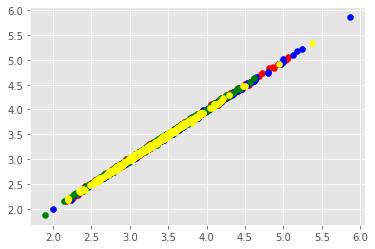

In [ ]:
#Michael 12.11.2020, we make a scatter plot of the patent documents in the latent space

encoded_text_A61M5_145 = encoder.predict(y[0:350,:])
encoded_text_E04C3_04 = encoder.predict(y[350:700,:])
encoded_text_F25B30_00 = encoder.predict(y[700:1050,:])
encoded_text_G01P7_00 = encoder.predict(y[1050:,:])
encoded_text_x_test = encoder.predict(x_test)
encoded_text_y = encoder.predict(y)

#plt.scatter(encoded_text[0::,0], encoded_text[0::,1])
#plt.colorbar()
plt.scatter(encoded_text_A61M5_145[0::,0], encoded_text_A61M5_145[0::,1], color="red")
plt.scatter(encoded_text_E04C3_04[0::,0], encoded_text_E04C3_04[0::,1], color="blue")
plt.scatter(encoded_text_F25B30_00[0::,0], encoded_text_F25B30_00[0::,1], color="green")
plt.scatter(encoded_text_G01P7_00[0::,0], encoded_text_G01P7_00[0::,1], color="yellow")
#plt.scatter(encoded_text_x_test[0:10:,0], encoded_text_x_test[0:10:,1], color="black")
#plt.scatter(encoded_text_y[0::,0], encoded_text_y[0::,1], color="black")
#plt.scatter(encoded_text[0::,0], encoded_text[0::,1:2], color="black")
plt.show()

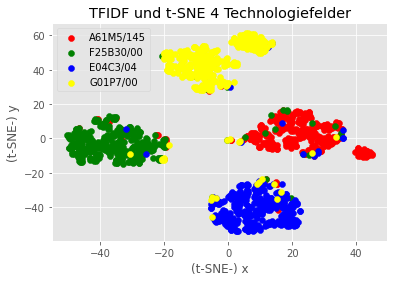

In [ ]:
#Michael 12.11.2020, we reduce dimension via t-SNE to d=2
from sklearn.manifold import TSNE
# brauchen wir nicht mehr - X_embedded_A61M5_145 = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_A61M5_145)
# brauchen wir nicht mehr - X_embedded_E04C3_04 = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_E04C3_04)
# brauchen wir nicht mehr - X_embedded_F25B30_00 = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_F25B30_00)
# brauchen wir nicht mehr - X_embedded_G01P7_00 = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_G01P7_00)
# brauchen wir nicht mehr - X_embedded_G01P7_00 = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_G01P7_00)
# brauchen wir nicht mehr - X_embedded_x_test = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_x_test)
#X_embedded_y = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_y)

#Michael 12.11.2020, Hier werden wir das t-SNE zweimal direkt hintereinander an
X_embedded_y = TSNE(n_components=2, random_state=10).fit_transform(X)
X_embedded_y = TSNE(n_components=2, random_state=10).fit_transform(X_embedded_y)

X_embedded_A61M5_145_tSNE = X_embedded_y[0:350,:]
X_embedded_E04C3_04_tSNE = X_embedded_y[350:700,:]
X_embedded_F25B30_00_tSNE = X_embedded_y[700:1050,:]
X_embedded_G01P7_00_tSNE = X_embedded_y[1050:,:]
#X_embedded_noise_tSNE = X_embedded_y[1400:,:]

plt.scatter(X_embedded_A61M5_145_tSNE[0::,0], X_embedded_A61M5_145_tSNE[0::,1], color="red", label="A61M5/145")
plt.scatter(X_embedded_F25B30_00_tSNE[0::,0], X_embedded_F25B30_00_tSNE[0::,1], color="green", label="F25B30/00")
plt.scatter(X_embedded_E04C3_04_tSNE[0::,0], X_embedded_E04C3_04_tSNE[0::,1], color="blue", label="E04C3/04")
plt.scatter(X_embedded_G01P7_00_tSNE[0::,0], X_embedded_G01P7_00_tSNE[0::,1], color="yellow", label="G01P7/00")
#plt.scatter(X_embedded_noise_tSNE[0::,0], X_embedded_noise_tSNE[0::,1], color="black")
#plt.scatter(X_embedded_x_test[0::,0], X_embedded_x_test[0::,1:2], color="black")
#plt.scatter(X_embedded_y[0::,0], X_embedded_y[0::,1], color="black")
plt.title("TFIDF und t-SNE 4 Technologiefelder")
plt.xlabel("(t-SNE-) x")
plt.ylabel("(t-SNE-) y")
plt.legend(loc="upper left")
plt.savefig('4_TF.png')
plt.show()

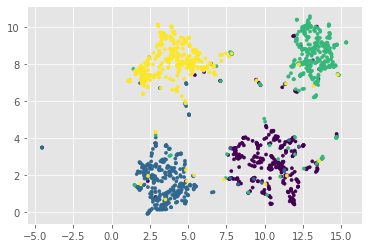

In [ ]:
#Michael 28.11.2020, Methode von Aris, Modul 3, Donnerstag, erstes Notebook (2D-Darstellung der Daten, ähnlich zu t-SNE)
import umap
umap_model = umap.UMAP(n_neighbors=4, n_components=2, random_state=1711)
umap_mnist = umap_model.fit_transform(X)
plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1], c=label, s=10)

In [ ]:
umap_mnist

array([[ 8.214693 ,  1.8509859],
       [ 9.482014 ,  3.7269092],
       [12.734643 ,  2.3231473],
       ...,
       [ 2.9286397,  7.4098234],
       [ 3.2881896,  9.590432 ],
       [ 3.9639428,  9.284313 ]], dtype=float32)

In [ ]:
#Michael 22.11.20, hier soll eine Separierung der Daten vorgenommen werden
from matplotlib.colors import ListedColormap
def plot_decision_regions(X,y,classifier, resolution=0.02):
    markers = ("s", "x", "o", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolor="black")

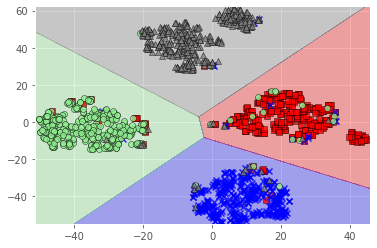

In [ ]:
#Michael 28.11.20, Logistic Regression as interpretable Machine Learning
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1, solver="lbfgs", multi_class="ovr")

x_train_lr, x_test_lr, label_train, label_test = train_test_split(X_embedded_y, label, test_size=0.25, random_state=42)
lr.fit(x_train_lr, label_train)

plot_decision_regions(X_embedded_y, label, classifier=lr)

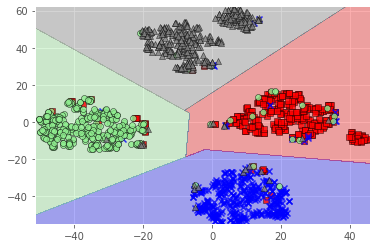

In [ ]:
#Michael 22.11.20, hier soll eine Separierung der Daten vorgenommen werden

#X_embedded_y = X_embedded_y/X_embedded_y.max()
from sklearn.svm import SVC
svm = SVC(kernel="linear", C=1.0, random_state=1)
svm.fit(x_train_lr, label_train)
plot_decision_regions(X_embedded_y, label, classifier=svm)

In [ ]:
terms = vectorizer.get_feature_names()

In [ ]:
X[0:350,:].shape

(350, 14924)

In [ ]:
x_test_encoded = encoder.predict(x_test)

In [ ]:
#######################
#######################
#######################

In [ ]:
#Michael 12.11.2020, we create a sparse autoencoder
from keras import regularizers

encoding_dim = 2

input_text = keras.Input(shape=(z,))
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_text)
decoded = layers.Dense(z, activation='sigmoid')(encoded)

autoencoder = keras.Model(input_text, decoded)

In [ ]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_text, encoded)
# This is our encoded input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=20,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 1050 samples, validate on 350 samples
Epoch 1/10
1050/1050 [==============================] - 0s 435us/step - loss: 0.6810 - val_loss: 0.6678
Epoch 2/10
1050/1050 [==============================] - 0s 316us/step - loss: 0.6556 - val_loss: 0.6429
Epoch 3/10
1050/1050 [==============================] - 0s 316us/step - loss: 0.6312 - val_loss: 0.6189
Epoch 4/10
1050/1050 [==============================] - 0s 309us/step - loss: 0.6077 - val_loss: 0.5959
Epoch 5/10
1050/1050 [==============================] - 0s 307us/step - loss: 0.5851 - val_loss: 0.5739
Epoch 6/10
1050/1050 [==============================] - 0s 312us/step - loss: 0.5635 - val_loss: 0.5527
Epoch 7/10
1050/1050 [==============================] - 0s 306us/step - loss: 0.5428 - val_loss: 0.5324
Epoch 8/10
1050/1050 [==============================] - 0s 308us/step - loss: 0.5229 - val_loss: 0.5129
Epoch 9/10
1050/1050 [==============================] - 0s 322us/step - loss: 0.5038 - val_loss: 0.4943
Epoch 10/10
1050/

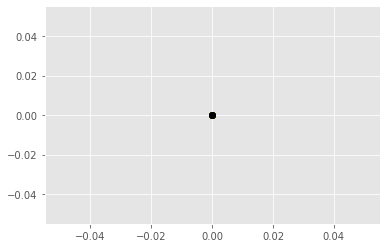

In [ ]:
#Michael 12.11.2020, we make a scatter plot of the patent documents in the latent space
#This is our encoded input
encoded_input = keras.Input(shape=(encoding_dim,))

#Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

#Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

encoded_text_A61M5_145 = encoder.predict(X[0:350,:])
encoded_text_E04C3_04 = encoder.predict(X[350:700,:])
encoded_text_F25B30_00 = encoder.predict(X[700:1050,:])
encoded_text_G01P7_00 = encoder.predict(X[1050:,:])
encoded_text_x_test = encoder.predict(x_test)

#plt.scatter(encoded_text[0::,0], encoded_text[0::,1])
#plt.colorbar()
plt.scatter(encoded_text_A61M5_145[0::,0], encoded_text_A61M5_145[0::,1], color="red")
plt.scatter(encoded_text_E04C3_04[0::,0], encoded_text_E04C3_04[0::,1], color="blue")
plt.scatter(encoded_text_F25B30_00[0::,0], encoded_text_F25B30_00[0::,1], color="green")
plt.scatter(encoded_text_G01P7_00[0::,0], encoded_text_G01P7_00[0::,1], color="yellow")
plt.scatter(encoded_text_x_test[0:10:,0], encoded_text_x_test[0:10:,1], color="black")

#plt.scatter(encoded_text[0::,0], encoded_text[0::,1:2], color="black")
plt.show()

In [ ]:
################################################
################################################
################################################
################################################
################################################
#Michael 12.11.2020, we create a DEEP autoencoder
input_text = keras.Input(shape=(z,))

#encoded = layers.Dense(8192, activation='relu')(input_text)
#encoded1 = layers.Dense(4096, activation='relu')(input_text)
#encoded = layers.Dense(2048, activation='relu')(encoded)
encoded2 = layers.Dense(1024, activation='relu')(input_text)
#encoded = layers.Dense(512, activation='relu')(encoded)
encoded3 = layers.Dense(256, activation='relu')(encoded2)
#encoded = layers.Dense(128, activation='relu')(encoded)
encoded4 = layers.Dense(64, activation='relu')(encoded3)
#encoded = layers.Dense(32, activation='relu')(encoded)
encoded5 = layers.Dense(16, activation='relu')(encoded4)
#encoded = layers.Dense(8, activation='relu')(encoded)
encoded = layers.Dense(2, activation='sigmoid')(encoded5)

decoded = layers.Dense(8, activation='relu')(encoded)
decoded = layers.Dense(16, activation='relu')(decoded)
#decoded = layers.Dense(32, activation='relu')(decoded)
decoded = layers.Dense(64, activation='relu')(decoded)
#decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(256, activation='relu')(decoded)
#decoded = layers.Dense(512, activation='relu')(decoded)
ecoded = layers.Dense(1024, activation='relu')(decoded)
#decoded = layers.Dense(2048, activation='relu')(decoded)
#decoded = layers.Dense(4096, activation='relu')(decoded)
#decoded = layers.Dense(8192, activation='relu')(decoded)
decoded = layers.Dense(z, activation='sigmoid')(decoded)

In [ ]:
autoencoder = keras.Model(input_text, decoded)
encoder = keras.Model(input_text, encoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=20,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 1050 samples, validate on 350 samples
Epoch 1/10
1050/1050 [==============================] - 1s 971us/step - loss: 0.4510 - val_loss: 0.0263
Epoch 2/10
1050/1050 [==============================] - 1s 667us/step - loss: 0.0068 - val_loss: 0.0041
Epoch 3/10
1050/1050 [==============================] - 1s 651us/step - loss: 0.0038 - val_loss: 0.0037
Epoch 4/10
1050/1050 [==============================] - 1s 659us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 5/10
1050/1050 [==============================] - 1s 665us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 6/10
1050/1050 [==============================] - 1s 652us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 7/10
1050/1050 [==============================] - 1s 629us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/10
1050/1050 [==============================] - 1s 663us/step - loss: 0.0034 - val_loss: 0.0036
Epoch 9/10
1050/1050 [==============================] - 1s 632us/step - loss: 0.0034 - val_loss: 0.0036
Epoch 10/10
1050/

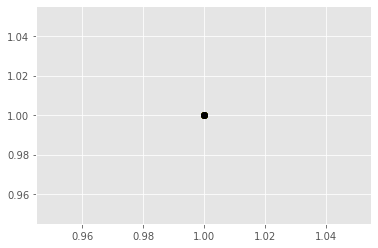

In [ ]:
#Michael 12.11.2020, we make a scatter plot of the patent documents in the latent space

encoded_text_A61M5_145 = encoder.predict(X[0:350,:])
encoded_text_E04C3_04 = encoder.predict(X[350:700,:])
encoded_text_F25B30_00 = encoder.predict(X[700:1050,:])
encoded_text_G01P7_00 = encoder.predict(X[1050:,:])
encoded_text_x_test = encoder.predict(x_test)
encoded_text_y = encoder.predict(y)

#plt.scatter(encoded_text[0::,0], encoded_text[0::,1])
#plt.colorbar()
plt.scatter(encoded_text_A61M5_145[0::,0], encoded_text_A61M5_145[0::,1], color="red")
plt.scatter(encoded_text_E04C3_04[0::,0], encoded_text_E04C3_04[0::,1], color="blue")
plt.scatter(encoded_text_F25B30_00[0::,0], encoded_text_F25B30_00[0::,1], color="green")
plt.scatter(encoded_text_G01P7_00[0::,0], encoded_text_G01P7_00[0::,1], color="yellow")
plt.scatter(encoded_text_x_test[0:10:,0], encoded_text_x_test[0:10:,1], color="black")
#plt.scatter(encoded_text[0::,0], encoded_text[0::,1:2], color="black")
plt.show()

In [ ]:
#Michael 29.11.2020, we try to evaluate, why the AE is not learning, by analyzing, whether the 4 TF-information
#in every layer does exist or not. Here we can plot the Neuron outputs of two neurons in a layer

def plot_AE_analysis_Neurons(X, layer, Neuron_1=0, Neuron_2=1, resolution=0.02):
    
    classifier = keras.Model(input_text, layer)

    encoded_text_A61M5_145 = classifier.predict(X[0:350,:])
    encoded_text_E04C3_04 = classifier.predict(X[350:700,:])
    encoded_text_F25B30_00 = classifier.predict(X[700:1050,:])
    encoded_text_G01P7_00 = classifier.predict(X[1050:,:])
    encoded_text_x_test = classifier.predict(x_test)
    encoded_text_y = classifier.predict(y)

    #plt.scatter(encoded_text[0::,0], encoded_text[0::,1])
    #plt.colorbar()
    plt.scatter(encoded_text_A61M5_145[0::,Neuron_1], encoded_text_A61M5_145[0::,Neuron_2], color="red")
    plt.scatter(encoded_text_E04C3_04[0::,Neuron_1], encoded_text_E04C3_04[0::,Neuron_2], color="blue")
    plt.scatter(encoded_text_F25B30_00[0::,Neuron_1], encoded_text_F25B30_00[0::,Neuron_2], color="green")
    plt.scatter(encoded_text_G01P7_00[0::,Neuron_1], encoded_text_G01P7_00[0::,Neuron_2], color="yellow")
    plt.scatter(encoded_text_x_test[0:10:,Neuron_1], encoded_text_x_test[0:10:,Neuron_2], color="black")
    #plt.scatter(encoded_text[0::,Pixel_1], encoded_text[0::,Pixel_2], color="black")
    plt.show()

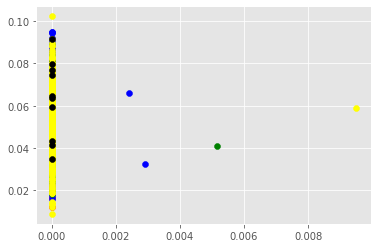

In [ ]:
#Michael 29.11.2020, plotting function plot_AE_analysis_Neurons
plot_AE_analysis_Neurons(X, encoded2)

In [ ]:
import umap

#Michael 29.11.2020, we try to evaluate, why the AE is not learning, by analyzing, whether the 4 TF-information
#in every layer does exist or not.  Here we can map the Neuron outputs of ALL neurons in a layer with umap or t-SNE

def plot_AE_analysis_Layers(X, label, layer, n_neigh=4, n_comp=2, random_st=1711):

    classifier = keras.Model(input_text, layer)
    encoded = classifier.predict(X)
    umap_model = umap.UMAP(n_neighbors=n_neigh, n_components=n_comp, random_state=random_st)
    umap_mnist = umap_model.fit_transform(encoded)
    plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1], c=label, s=10)

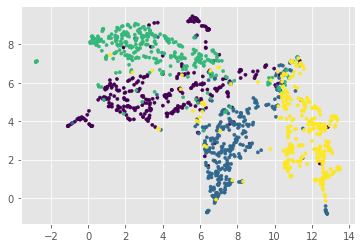

In [ ]:
#Michael 29.11.2020, plotting function plot_AE_analysis_Layers
plot_AE_analysis_Layers(X, label, encoded2)

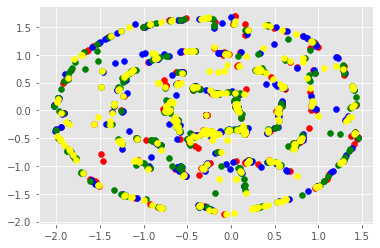

In [ ]:
#Michael 12.11.2020, we reduce dimension via t-SNE to d=2
from sklearn.manifold import TSNE
X_embedded_A61M5_145 = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_A61M5_145)
X_embedded_E04C3_04 = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_E04C3_04)
X_embedded_F25B30_00 = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_F25B30_00)
X_embedded_G01P7_00 = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_G01P7_00)
X_embedded_G01P7_00 = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_G01P7_00)
X_embedded_x_test = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_x_test)
X_embedded_y = TSNE(n_components=2, random_state=10).fit_transform(encoded_text_y)

X_embedded_A61M5_145_tSNE = X_embedded_y[0:350,:]
X_embedded_E04C3_04_tSNE = X_embedded_y[350:700,:]
X_embedded_F25B30_00_tSNE = X_embedded_y[700:1050,:]
X_embedded_G01P7_00_tSNE = X_embedded_y[1050:,:]

plt.scatter(X_embedded_A61M5_145_tSNE[0::,0], X_embedded_A61M5_145_tSNE[0::,1], color="red")
plt.scatter(X_embedded_E04C3_04_tSNE[0::,0], X_embedded_E04C3_04_tSNE[0::,1], color="blue")
plt.scatter(X_embedded_F25B30_00_tSNE[0::,0], X_embedded_F25B30_00_tSNE[0::,1], color="green")
plt.scatter(X_embedded_G01P7_00_tSNE[0::,0], X_embedded_G01P7_00_tSNE[0::,1], color="yellow")
#plt.scatter(X_embedded_x_test[0::,0], X_embedded_x_test[0::,1:2], color="black")
#plt.scatter(X_embedded_y[0::,0], X_embedded_y[0::,1:2], color="black")
plt.show()

In [ ]:
x_test_encoded[0::,0]*1000

array([5052.9077, 3537.1282, 2889.475 , 3276.484 , 3277.8547, 3648.6357,
       3913.1404, 5002.2246, 3705.314 , 3560.206 , 2820.4802, 3188.751 ,
       3243.3655, 2598.469 , 3041.226 , 3354.5908, 3973.946 , 3587.169 ,
       3158.7957, 3292.1323, 2386.5315, 4006.1301, 2688.8135, 3889.824 ,
       4322.906 , 3758.5652, 3355.2832, 3737.4846, 3387.8064, 3332.9373,
       4142.327 , 3976.112 , 2334.4336, 3219.571 , 3578.8442, 3707.8328,
       3483.0225, 3874.341 , 2819.558 , 3215.946 , 2832.1523, 2794.6436,
       2741.3289, 3368.766 , 3277.3623, 3479.6445, 3099.165 , 3811.3005,
       4170.231 , 3773.537 , 4183.635 , 2545.8796, 3369.5085, 3349.4993,
       3652.0916, 2551.5605, 2841.6033, 3387.5066, 3751.38  , 3564.7651,
       2877.7634, 3576.0168, 4246.1367, 3686.2542, 3928.1973, 3338.1216,
       2581.0457, 3677.5642, 3489.0378, 3502.7039, 3487.4187, 3521.2026,
       4372.652 , 2857.6743, 4410.7275, 3625.6133, 3703.656 , 4164.2666,
       2783.409 , 3161.415 , 3823.437 , 3460.2463, 

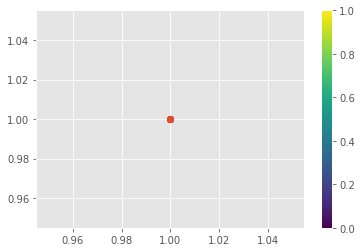

In [ ]:
x_test_encoded = encoder.predict(x_test)
#plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0::,0], x_test_encoded[0::,1])
plt.colorbar()
plt.show()

In [ ]:
#######################
#######################
#######################

In [ ]:
z

14924

In [ ]:
#Michael 12.11.2020, we create a CNN autoencoder, here in 1D
import keras
from keras import layers

input_text = keras.Input(shape=(z,1))

x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(input_text)
x = layers.MaxPooling1D(10, padding='same')(x)
x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
x = layers.MaxPooling1D(10, padding='same')(x)
x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
x = layers.MaxPooling1D(10, padding='same')(x)
x = layers.Conv1D(filters=16, kernel_size=3, activation='sigmoid', padding="same")(x)
encoded = layers.MaxPooling1D(10, padding='same')(x)
#encoded = keras.layers.Dense(2, activation='relu')(x)

x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(encoded)
x = layers.UpSampling1D(8)(x)
x = layers.Conv1D(filters=16, kernel_size=2, activation='relu', padding="valid")(x)
x = layers.UpSampling1D(10)(x)
x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
x = layers.UpSampling1D(10)(x)
x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding="same")(x)
x = layers.UpSampling1D(10)(x)
x = layers.Conv1D(filters=16, kernel_size=39, activation='relu', padding="valid")(x)
x = layers.Conv1D(filters=16, kernel_size=39, activation='relu', padding="valid")(x)
decoded = layers.Conv1D(filters=1, kernel_size=3, activation='sigmoid', padding="same")(x)

#x2 = keras.layers.Dense(8, activation='relu')(encoded)
#x2 = keras.layers.Dense(32, activation='relu')(x2)
#decoded = keras.layers.Dense(z, activation='sigmoid')(x2)


# at this point the representation is (4, 4, 8) i.e. 128-dimensional

#x = layers.Conv1D(filters=16, kernel_size=3, activation='relu')(encoded)
#x = layers.UpSampling1D(2)(x)
#decoded = layers.Conv1D(filters=16, kernel_size=3, activation='sigmoid')(x)

autoencoder = keras.Model(input_text, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
x_train = np.reshape(x_train, (len(x_train), z, 1))
x_test = np.reshape(x_test, (len(x_test), z, 1))

In [ ]:
autoencoder.summary()
x_train.shape

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 14924, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 14924, 16)         64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1493, 16)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1493, 16)          784       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 150, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 150, 16)           784       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 15, 16)            0  

(1050, 14924, 1)

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=25,
                shuffle=True, validation_data=(x_test, x_test))

Train on 1050 samples, validate on 350 samples
Epoch 1/10
1050/1050 [==============================] - 12s 12ms/step - loss: 0.1807 - val_loss: 0.0127
Epoch 2/10
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0102 - val_loss: 0.0075
Epoch 3/10
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 4/10
1050/1050 [==============================] - 4s 4ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 5/10
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 6/10
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 7/10
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 8/10
1050/1050 [==============================] - 4s 3ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 9/10
1050/1050 [==============================] - 3s 3ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 10/10
1050/1050 [==========

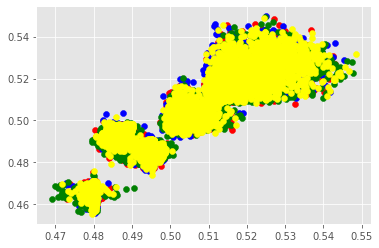

In [ ]:
#Michael 22.11.2020, we make a scatter plot of the patent documents in the latent space
# This model maps an input to its encoded representation
#The file y has to be reshaped to Y due to CNN
encoder = keras.Model(input_text, encoded)
Y = np.reshape(y, (len(y), z, 1))

encoded_text_A61M5_145 = encoder.predict(Y[0:350,:])
encoded_text_E04C3_04 = encoder.predict(Y[350:700,:])
encoded_text_F25B30_00 = encoder.predict(Y[700:1050,:])
encoded_text_G01P7_00 = encoder.predict(Y[1050:,:])
encoded_text_x_test = encoder.predict(x_test)
encoded_text_y = encoder.predict(Y)

#plt.scatter(encoded_text[0::,0], encoded_text[0::,1])
#plt.colorbar()
plt.scatter(encoded_text_A61M5_145[0::,0], encoded_text_A61M5_145[0::,1], color="red")
plt.scatter(encoded_text_E04C3_04[0::,0], encoded_text_E04C3_04[0::,1], color="blue")
plt.scatter(encoded_text_F25B30_00[0::,0], encoded_text_F25B30_00[0::,1], color="green")
plt.scatter(encoded_text_G01P7_00[0::,0], encoded_text_G01P7_00[0::,1], color="yellow")
#plt.scatter(encoded_text_x_test[0:10:,0], encoded_text_x_test[0:10:,1], color="black")
#plt.scatter(encoded_text_y[0::,0], encoded_text_y[0::,1], color="black")
#plt.scatter(encoded_text[0::,0], encoded_text[0::,1:2], color="black")
plt.show()

##Chat Data

In [ ]:
#Here are the chat-data
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################

In [ ]:
dataframe_chat = pd.read_excel("Chat.xlsx", header=None)
data_chat = np.array(dataframe_chat)
data_chat = data_chat.flatten()

In [ ]:
custom_stops_chat = ["abend", "aber", "alle", "als", "am", "an", "auf", "auch", "bei", "bitte", "ch", "da", "dank", "danke", "dann", "das", "dass", "de", "dem",\
                     "den", "der", "die", "dies", "daher",\
                     "diese", "ebenfalls","ein", "eine", "einen", "es", "euch", "für", "gerade", "gerne", "guten", "grüsse", "hallo",\
                     "habe", "haben", "hier","http", "https", "ich", "ihnen", "ihre", "ihrem", "ihren", "im", "in", "ist", "ja", "kann", "können",\
                     "kurz", "mein", "meine", "meinen", "mich", "mir", "mit",\
                     "möchte", "muss", "nicht", "noch", "nur", "oder", "schönen", "sich", "sie", "sind", "sollte", "tag", "und",\
                     "unter", "von","was", "welche", "welcher", "wenn", "werde", "wie", "wir", "www", "zu"] 
vectorizer = TfidfVectorizer(max_df=0.2, stop_words=custom_stops_chat)
#vectorizer = TfidfVectorizer(max_df=0.7, stop_words="english")

# 06.09.2020, Michael
X_chat = vectorizer.fit_transform(data_chat)

import operator
dict = vectorizer.vocabulary_
sorted_dict = sorted(dict.items(), key=operator.itemgetter(1))

print(vectorizer.get_feature_names())
print(sorted_dict)
#print((X.todense()))

['00', '000', '000er', '001', '0016', '0041', '0077', '00h', '00uhr', '01', '012000998', '02', '0245', '025', '026', '03', '031', '031320', '0313207875', '0313209111', '0317656022', '031952', '0319522250', '031er', '032', '034', '0355', '03_freizuegigkeitskonto_factsheet_d', '04', '041', '0414205805', '044', '05', '0503', '0504', '052', '053', '056', '058', '05_factsheet_trend_set_d', '06', '061', '062', '063', '0630', '06300', '07', '076', '0766342709', '078', '079', '0795447567', '0798891970', '08', '09', '090', '10', '100', '1000', '100000', '100fr', '100k', '101', '1015', '10310', '1035', '10k', '11', '1100', '110000chf', '110x260x460', '111', '116', '12', '120', '1200', '122', '127', '12722', '1282', '1285', '12x', '13', '1300', '13000', '1330', '14', '140', '141', '144', '1485', '15', '150', '1500', '150fr', '150x260x460', '1525', '155', '1570', '15h', '16', '169', '17', '172', '1720', '1790', '18', '180', '1810447', '19', '1982', '1993', '1996', '1997', '1998', '1a', '1er', '1h'

In [ ]:
z_chat = X_chat.shape[1]
print(X_chat.shape)
print(z_chat)

(9558, 8213)
8213


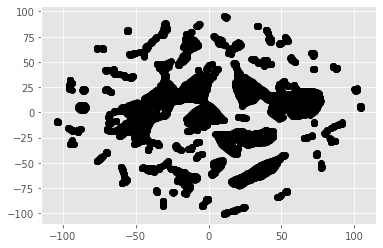

In [ ]:
#Michael 14.11.2020, we reduce dimension via t-SNE to d=2
from sklearn.manifold import TSNE
X_embedded_chat = TSNE(n_components=2, random_state=10).fit_transform(X_chat)
X_embedded_chat = TSNE(n_components=2, random_state=10).fit_transform(X_embedded_chat)
X_embedded_chat = TSNE(n_components=2, random_state=10).fit_transform(X_embedded_chat)

plt.scatter(X_embedded_chat[0::,0], X_embedded_chat[0::,1], color="black")
plt.show()

In [ ]:
#Michael 28.11.2020, Methode von Aris, Modul 3, Donnerstag, erstes Notebook (2D-Darstellung der Daten, ähnlich zu t-SNE)
import umap
umap_model = umap.UMAP(n_neighbors=20, n_components=2, random_state=1711)
umap_mnist = umap_model.fit_transform(X_chat)
plt.scatter(umap_mnist[:, 0], umap_mnist[:, 1])#, s=10)

In [ ]:
from sklearn.model_selection import train_test_split
x_chat_train, x_chat_test = train_test_split(X_chat, test_size=0.25, random_state=42)

In [ ]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 2  # 2 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_text_chat = keras.Input(shape=(z_chat,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_text_chat)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(z_chat, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_text_chat, decoded)

In [ ]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_text_chat, encoded)

In [ ]:
# This is our encoded (4-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_chat_train, x_chat_train,
                epochs=10,
                batch_size=20,
                shuffle=True,
                validation_data=(x_chat_test, x_chat_test))

Train on 7168 samples, validate on 2390 samples
Epoch 1/10
7168/7168 [==============================] - 2s 288us/step - loss: 0.5114 - val_loss: 0.2795
Epoch 2/10
7168/7168 [==============================] - 2s 252us/step - loss: 0.1528 - val_loss: 0.0772
Epoch 3/10
7168/7168 [==============================] - 2s 251us/step - loss: 0.0494 - val_loss: 0.0321
Epoch 4/10
7168/7168 [==============================] - 2s 254us/step - loss: 0.0231 - val_loss: 0.0175
Epoch 5/10
7168/7168 [==============================] - 2s 253us/step - loss: 0.0135 - val_loss: 0.0112
Epoch 6/10
7168/7168 [==============================] - 2s 248us/step - loss: 0.0091 - val_loss: 0.0080
Epoch 7/10
7168/7168 [==============================] - 2s 251us/step - loss: 0.0067 - val_loss: 0.0061
Epoch 8/10
7168/7168 [==============================] - 2s 254us/step - loss: 0.0053 - val_loss: 0.0050
Epoch 9/10
7168/7168 [==============================] - 2s 249us/step - loss: 0.0044 - val_loss: 0.0042
Epoch 10/10
7168

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_text_chat = encoder.predict(X_chat)
decoded_text = decoder.predict(encoded_text)
print(decoded_text.shape)
encoded_text.shape

(1400, 8213)


(1400, 2)

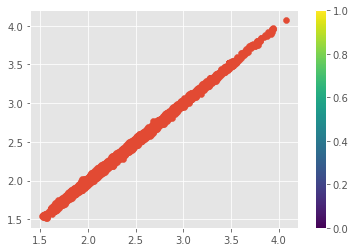

In [ ]:
#plt.figure(figsize=(6, 6))
plt.scatter(encoded_text_chat[0::,0], encoded_text_chat[0::,1])
plt.colorbar()
plt.show()

In [ ]:

#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################
#######################

In [ ]:
#Michael 09.11.2020, autoencoder according to tensorflow, here with the patent data
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
latent_dim = 2 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(z, activation='sigmoid'),
     # layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim) 

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
y = X.toarray()
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(y, test_size=0.25, random_state=42)

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 1050 samples, validate on 350 samples
Epoch 1/10
1050/1050 [==============================] - 4s 4ms/sample - loss: 0.2459 - val_loss: 0.2414
Epoch 2/10
1050/1050 [==============================] - 0s 284us/sample - loss: 0.2349 - val_loss: 0.2259
Epoch 3/10
1050/1050 [==============================] - 0s 275us/sample - loss: 0.2133 - val_loss: 0.1983
Epoch 4/10
1050/1050 [==============================] - 0s 263us/sample - loss: 0.1805 - val_loss: 0.1618
Epoch 5/10
1050/1050 [==============================] - 0s 269us/sample - loss: 0.1419 - val_loss: 0.1233
Epoch 6/10
1050/1050 [==============================] - 0s 299us/sample - loss: 0.1049 - val_loss: 0.0895
Epoch 7/10
1050/1050 [==============================] - 0s 285us/sample - loss: 0.0747 - val_loss: 0.0637
Epoch 8/10
1050/1050 [==============================] - 0s 296us/sample - loss: 0.0527 - val_loss: 0.0457
Epoch 9/10
1050/1050 [==============================] - 0s 276us/sample - loss: 0.0378 - val_loss: 0.0335
E

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_text_chat = encoder.predict(y)
decoded_text = decoder.predict(encoded_text)
print(decoded_text.shape)
encoded_text.shape

(1400, 14924)


(1400, 2)

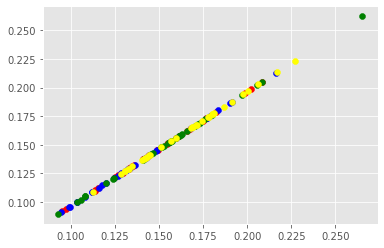

In [ ]:
#Michael 12.11.2020, we make a scatter plot of the patent documents in the latent space

encoded_text_A61M5_145 = autoencoder.predict(y[0:350:10,:])
encoded_text_E04C3_04 = autoencoder.predict(y[350:700:10,:])
encoded_text_F25B30_00 = autoencoder.predict(y[700:1050:10,:])
encoded_text_G01P7_00 = autoencoder.predict(y[1050::10,:])

#plt.scatter(encoded_text[0::,0], encoded_text[0::,1])
#plt.colorbar()
plt.scatter(encoded_text_A61M5_145[0::,0], encoded_text_A61M5_145[0::,1], color="red")
plt.scatter(encoded_text_E04C3_04[0::,0], encoded_text_E04C3_04[0::,1], color="blue")
plt.scatter(encoded_text_F25B30_00[0::,0], encoded_text_F25B30_00[0::,1], color="green")
plt.scatter(encoded_text_G01P7_00[0::,0], encoded_text_G01P7_00[0::,1], color="yellow")
#plt.scatter(encoded_text[0::,0], encoded_text[0::,1], color="black")
plt.show()